<a href="https://www.kaggle.com/code/aryandec25/notebook-stackoverflow?scriptVersionId=136321753" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing all the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import re
from wordcloud import WordCloud
from bs4 import BeautifulSoup


from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,classification_report

In [2]:
!unzip /kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
!unzip /kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip

Archive:  /kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
  inflating: Train.csv               
Archive:  /kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip
  inflating: Test.csv                


In [3]:
df_train = pd.read_csv('/kaggle/working/Train.csv').sample(500000)
df_test = pd.read_csv('/kaggle/working/Test.csv').sample(50000)

# Exploring the data

In [4]:
print(f'The shape of the Train dataset: {df_train.shape}')
print(f'The shape of the Train dataset: {df_test.shape}')

The shape of the Train dataset: (500000, 4)
The shape of the Train dataset: (50000, 3)


In [5]:
df_train.reset_index(drop = True,inplace=True)

In [6]:
df_train.head()

,Id,Title,Body,Tags
0,1052803,What are Visual Studio project references?,<p>I came across the Framework and References ...,c++ visual-studio visual-c++ visual-studio-pro...
1,441187,How to create a report of per-day changes over...,<p>I need to generate report that will show nu...,sql-server tsql data-warehouse scd2
2,5525782,Mac OS X Java SDK Support,"<p>Can anyone tell me, or send me to a page, t...",java osx
3,4965496,Security with RijndaelManaged and ServicePoint...,<p>I have a security question about <strong>Ri...,ssl rijndaelmanaged servicepointmanager
4,2081065,"Unlocking a ""read only"" registry entry in Wind...",<p>My registry entry <code>HKEY_CURRENT_USER\S...,windows-7 windows-registry


In [7]:
df_train['Body'][0]

'<p>I came across the Framework and References tab of my project and noticed that I can "Add New Reference..." to my project, what is this functionality?</p>\n'

In [8]:
df_train['Tags'][0]

'c++ visual-studio visual-c++ visual-studio-project'

In [9]:
print(f'Train DataFrame Shape: {df_train.shape}')

Train DataFrame Shape: (500000, 4)


## Data pre-processing

### Checking for duplicates

In [10]:
duplicated_pairs = df_train.sort_values('Title', ascending=False).duplicated('Title')
print(f'Total number of duplicated questions: {duplicated_pairs.sum()}')

df_train = df_train[~duplicated_pairs]
print(f'Dataframe shape after duplicate removal: {df_train.shape}')


Total number of duplicated questions: 14970
Dataframe shape after duplicate removal: (485030, 4)


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485030 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      485030 non-null  int64 
 1   Title   485030 non-null  object
 2   Body    485030 non-null  object
 3   Tags    485030 non-null  object
dtypes: int64(1), object(3)
memory usage: 18.5+ MB


In [12]:
df_train.isnull().sum()

Id       0
Title    0
Body     0
Tags     0
dtype: int64

In [13]:
df_train.dropna(axis=0, inplace=True)

In [14]:
df_train.isnull().sum()

Id       0
Title    0
Body     0
Tags     0
dtype: int64

In [15]:
from pprint import pprint

pprint(df_train.iloc[5].to_dict(), compact=True)

{'Body': '<p>I have created a Git repository on my Desktop machine (Windows 7) '
         'with:</p>\n'
         '\n'
         '<pre><code>git init\n'
         'git add &lt;all my files&gt;\n'
         'git commit -m "added my files"\n'
         '</code></pre>\n'
         '\n'
         '<p>Now I have installed a new Ubuntu Server 10.10 on a machine on my '
         'LAN and installed OpenSSH. My home directory is '
         '<code>/home/jonas</code> and I created a directory '
         '<code>~/code/</code> to contain my projects. I can log in to the '
         'Ubuntu Server from Windows 7 with Putty.</p>\n'
         '\n'
         '<p>I installed Git on the server with <code>sudo apt-get install '
         'git</code></p>\n'
         '\n'
         '<h2>Adding a remote repository</h2>\n'
         '\n'
         '<p>Now I want to add my Git repository on my Desktop to the Server. '
         'I tried to follow the instructions from <em>Pragmatic Version '
         'Control Using Git</em>.

#### Creating a tag count column as a new feature

In [16]:
df_train['Tag_Counts'] = df_train['Tags'].apply(lambda x: len(x.split()))

In [17]:
df_train[['Tags','Tag_Counts']]

,Tags,Tag_Counts
0,c++ visual-studio visual-c++ visual-studio-pro...,4
1,sql-server tsql data-warehouse scd2,4
2,java osx,2
3,ssl rijndaelmanaged servicepointmanager,3
4,windows-7 windows-registry,2
...,...,...
499995,c++ pointers,2
499996,ruby ajax sinatra,3
499997,git git-flow,2
499998,c++ exception gcc exception-handling g++,5


## Basic Data Analysis on Tags

### Frequency of tag_count

In [18]:
df_train['Tag_Counts'].value_counts()

3    138709
2    129337
4     93145
1     66537
5     57302
Name: Tag_Counts, dtype: int64

In [19]:
print( "Maximum number of tags in a question: ", df_train["Tag_Counts"].max())
print( "Minimum number of tags in a question: ", df_train["Tag_Counts"].min())
print( "Average number of tags in a question: ", df_train["Tag_Counts"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  2.8873018163824917


In [20]:
df_train

,Id,Title,Body,Tags,Tag_Counts
0,1052803,What are Visual Studio project references?,<p>I came across the Framework and References ...,c++ visual-studio visual-c++ visual-studio-pro...,4
1,441187,How to create a report of per-day changes over...,<p>I need to generate report that will show nu...,sql-server tsql data-warehouse scd2,4
2,5525782,Mac OS X Java SDK Support,"<p>Can anyone tell me, or send me to a page, t...",java osx,2
3,4965496,Security with RijndaelManaged and ServicePoint...,<p>I have a security question about <strong>Ri...,ssl rijndaelmanaged servicepointmanager,3
4,2081065,"Unlocking a ""read only"" registry entry in Wind...",<p>My registry entry <code>HKEY_CURRENT_USER\S...,windows-7 windows-registry,2
...,...,...,...,...,...
499995,3440230,Pointer alignment,<p>could anyone explain (by giving appropiate ...,c++ pointers,2
499996,3252996,Rails Ajax -> Sinatra -> Amazon API and back,<p>I'm not sure that I really understand how S...,ruby ajax sinatra,3
499997,4786023,Gitflow Installation Problems,<p>I am trying to get gitflow running on Windo...,git git-flow,2
499998,5687092,Zero cost exception handling vs setjmp/longjmp,<p>Assuming that there is a cost associated wi...,c++ exception gcc exception-handling g++,5


Something looks odd about this

In [21]:
df_train['Tag_Counts'].value_counts()

3    138709
2    129337
4     93145
1     66537
5     57302
Name: Tag_Counts, dtype: int64

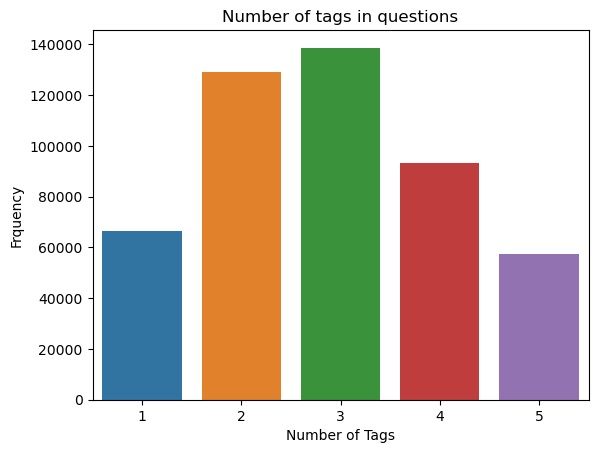

In [22]:
df_train_tag_freq = df_train['Tag_Counts'].value_counts().reset_index().sort_values(by='index').rename(columns = {'index':'tag_count', 'Tag_Counts':'tag_value_counts'})


plt.title('Number of tags in questions')
sns.barplot(data = df_train_tag_freq, x = 'tag_count', y = 'tag_value_counts')
plt.xlabel('Number of Tags')
plt.ylabel('Frquency')
plt.show()

#### Observations: 
1. Maximum number of tags in question: 5
2. Minimum number of tags in question: 1
3. Average number of tags in question: 2.89
4. Most of the questions have either 2 or 3 tags to work with.

### Total number of unique Tags

In [23]:
vectorizer = CountVectorizer(tokenizer = lambda x : x.split())
tag_bow = vectorizer.fit_transform(df_train['Tags'])

In [24]:
tag_bow.shape

(485030, 30286)

In [25]:
print("Number of questions :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

Number of questions : 485030
Number of unique tags : 30286


In [26]:
tags = vectorizer.get_feature_names_out()
print("Few tags :", tags[:10])

Few tags : ['.a' '.app' '.asp.net-mvc' '.aspxauth' '.bash-profile' '.class-file'
 '.doc' '.each' '.emf' '.exe']


In [27]:
df_train.head()

,Id,Title,Body,Tags,Tag_Counts
0,1052803,What are Visual Studio project references?,<p>I came across the Framework and References ...,c++ visual-studio visual-c++ visual-studio-pro...,4
1,441187,How to create a report of per-day changes over...,<p>I need to generate report that will show nu...,sql-server tsql data-warehouse scd2,4
2,5525782,Mac OS X Java SDK Support,"<p>Can anyone tell me, or send me to a page, t...",java osx,2
3,4965496,Security with RijndaelManaged and ServicePoint...,<p>I have a security question about <strong>Ri...,ssl rijndaelmanaged servicepointmanager,3
4,2081065,"Unlocking a ""read only"" registry entry in Wind...",<p>My registry entry <code>HKEY_CURRENT_USER\S...,windows-7 windows-registry,2


### Frequency of each tag

In [28]:
freq = tag_bow.sum(axis = 0).A1
tag_to_count_map = dict(zip(tags,freq))

In [29]:
freq

array([ 2,  6,  1, ..., 67,  2,  3])

In [30]:
print(f'Shape of Freqeuency: {freq.shape}')
print(f'Shape of Tags: {tags.shape}')


Shape of Freqeuency: (30286,)
Shape of Tags: (30286,)


In [31]:
list = []
for key, value in tag_to_count_map.items():
  list.append([key, value]) 


tag_df_train = pd.DataFrame(list, columns=['Tags', 'Counts'])
tag_df_train.head()

,Tags,Counts
0,.a,2
1,.app,6
2,.asp.net-mvc,1
3,.aspxauth,1
4,.bash-profile,16


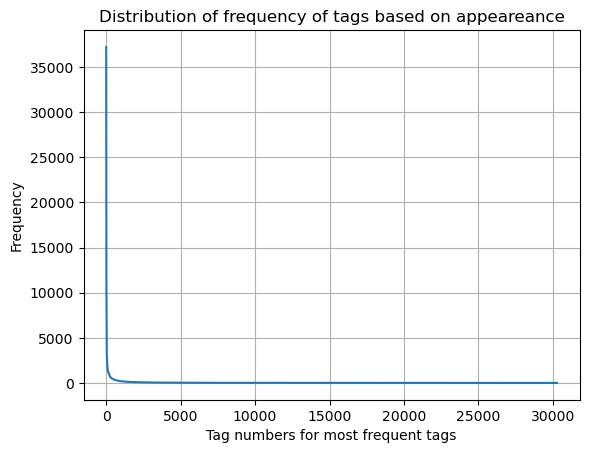

In [32]:
tag_df_train_sorted = tag_df_train.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_train_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.show()

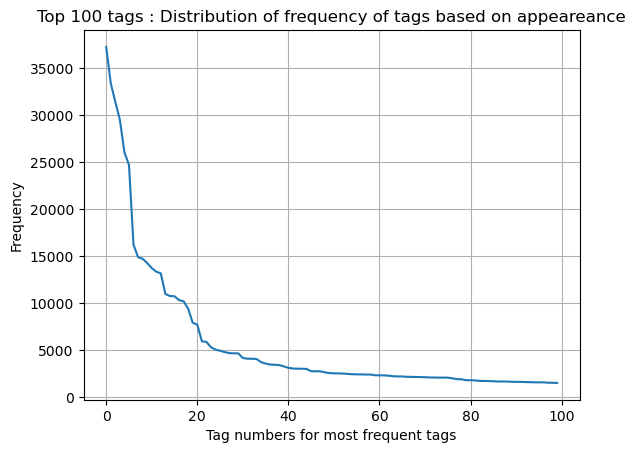

In [33]:
plt.plot(tag_df_train_sorted['Counts'][0:100].values)
plt.grid()
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.show()

In [34]:
tag_bow

<485030x30286 sparse matrix of type '<class 'numpy.int64'>'
	with 1400428 stored elements in Compressed Sparse Row format>

Data pre-processing

- Cleaning up the title and body
- realtion with name of the tag and title or body
- Present of code snippet based on body. 
- Length of the body
- if any attachment  with the questions. 
- Url attachments
- Synonymn of tags in title or body.


In [35]:
df_train

,Id,Title,Body,Tags,Tag_Counts
0,1052803,What are Visual Studio project references?,<p>I came across the Framework and References ...,c++ visual-studio visual-c++ visual-studio-pro...,4
1,441187,How to create a report of per-day changes over...,<p>I need to generate report that will show nu...,sql-server tsql data-warehouse scd2,4
2,5525782,Mac OS X Java SDK Support,"<p>Can anyone tell me, or send me to a page, t...",java osx,2
3,4965496,Security with RijndaelManaged and ServicePoint...,<p>I have a security question about <strong>Ri...,ssl rijndaelmanaged servicepointmanager,3
4,2081065,"Unlocking a ""read only"" registry entry in Wind...",<p>My registry entry <code>HKEY_CURRENT_USER\S...,windows-7 windows-registry,2
...,...,...,...,...,...
499995,3440230,Pointer alignment,<p>could anyone explain (by giving appropiate ...,c++ pointers,2
499996,3252996,Rails Ajax -> Sinatra -> Amazon API and back,<p>I'm not sure that I really understand how S...,ruby ajax sinatra,3
499997,4786023,Gitflow Installation Problems,<p>I am trying to get gitflow running on Windo...,git git-flow,2
499998,5687092,Zero cost exception handling vs setjmp/longjmp,<p>Assuming that there is a cost associated wi...,c++ exception gcc exception-handling g++,5


In [36]:
df_train['Body'][1]

"<p>I need to generate report that will show number of new / changed rows on per-day basis for SCD table.</p>\n\n<p>Here is the SQL to create the table:</p>\n\n<pre><code>create table #scd(\n  code      nvarchar not null\n, startdate date     not null\n, enddate   date\n);\nalter table #scd add constraint pk_scd primary key (code, startdate);\n\n\ninsert into #scd values\n ('A', '2012-06-01', '2012-06-02')\n,('B', '2012-06-01', '2012-06-02')\n,('A', '2012-06-02', '2012-06-03')\n,('B', '2012-06-02', '2012-06-04')\n,('A', '2012-06-03', '2012-06-04')\n,('A', '2012-06-04', null)\n,('B', '2012-06-04', null)\n,('C', '2012-06-04', null)\n\nselect * from #scd\n</code></pre>\n\n<p>The result look like this:</p>\n\n<pre><code>code    startdate   enddate\nA   2012-06-01  2012-06-02\nB   2012-06-01  2012-06-02\nA   2012-06-02  2012-06-03\nB   2012-06-02  2012-06-04\nA   2012-06-03  2012-06-04\nA   2012-06-04  NULL\nB   2012-06-04  NULL\nC   2012-06-04  NULL\n</code></pre>\n\n<p>Now, I need to prod

In [37]:
tag_df_train_sorted

,Tags,Counts
3186,c#,37243
13085,java,33392
19634,php,31401
13153,javascript,29518
909,android,26042
...,...,...
24792,srt,1
13816,jython-2.5,1
24790,srpms,1
20093,popupmenubutton,1


In [38]:
print("{} tags are used more than 25 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>25].shape[0]))
print("{} tags are used more than 50 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>50].shape[0]))

4962 tags are used more than 25 times
3077 tags are used more than 50 times


### Observations:
1. 144 tags are used more than 25 times.
2. 59 tags are used more than 50 times.
3. C# is most frequently used tag 778 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

## Word map

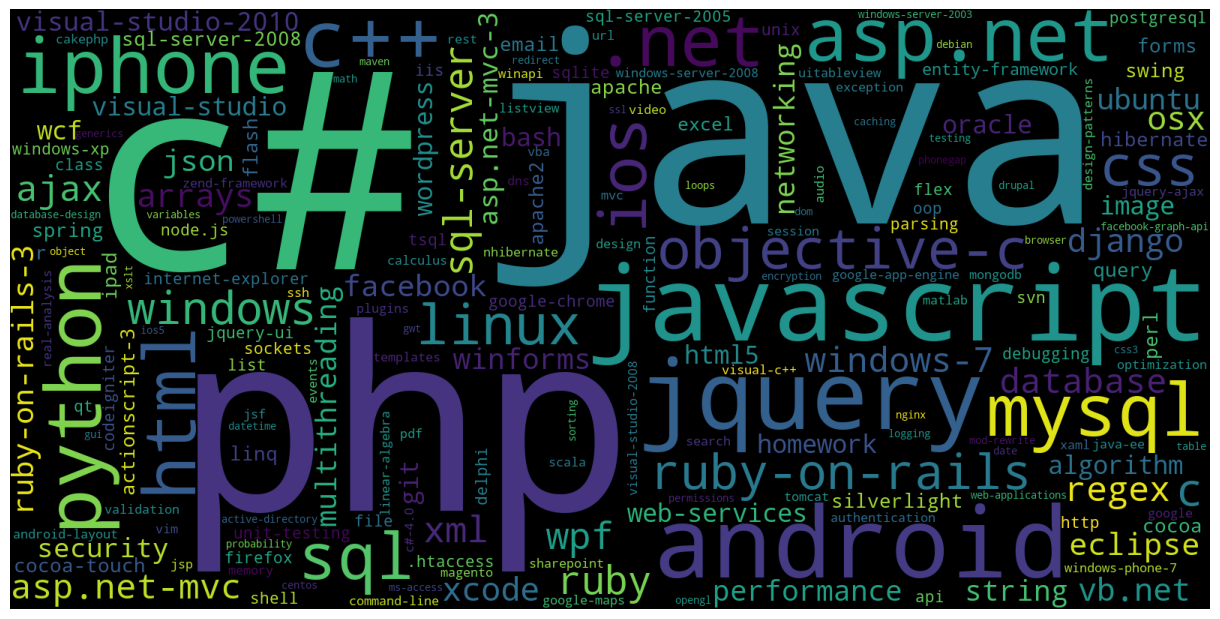

In [39]:
tag_to_count_map
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

### Barplot of top 20 tags

In [40]:
tag_df_train_sorted.reset_index(drop=True)

,Tags,Counts
0,c#,37243
1,java,33392
2,php,31401
3,javascript,29518
4,android,26042
...,...,...
30281,srt,1
30282,jython-2.5,1
30283,srpms,1
30284,popupmenubutton,1


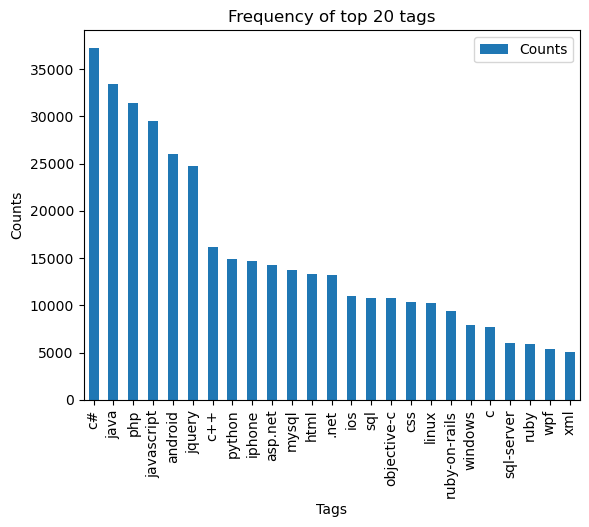

In [41]:
i=np.arange(25)
tag_df_train_sorted.head(25).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_train_sorted['Tags'].head(25))
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [42]:
print("{} tags are used more than 25 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>25].shape[0]))
print("{} tags are used more than 50 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>50].shape[0]))

4962 tags are used more than 25 times
3077 tags are used more than 50 times


In [43]:
tag_df_train_sorted['Tags']

3186                  c#
13085               java
19634                php
13153         javascript
909              android
              ...       
24792                srt
13816         jython-2.5
24790              srpms
20093    popupmenubutton
8901                 feh
Name: Tags, Length: 30286, dtype: object

<Axes: xlabel='Body_Length', ylabel='Tag_Counts'>

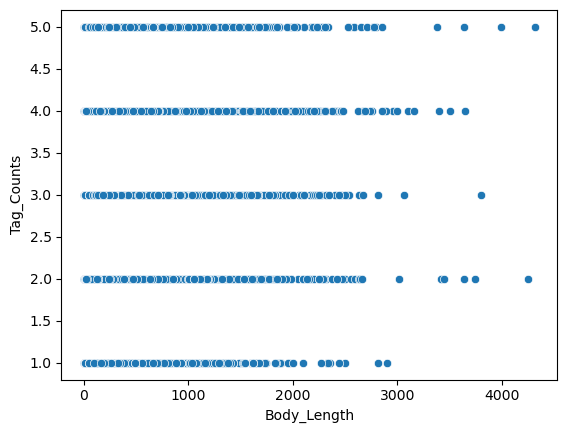

In [44]:
df_train['Body_Length'] = df_train['Body'].apply(lambda x : len(x.split()))
sns.scatterplot(x= df_train['Body_Length'], y = df_train['Tag_Counts'])

<Axes: xlabel='Title_Length', ylabel='Tag_Counts'>

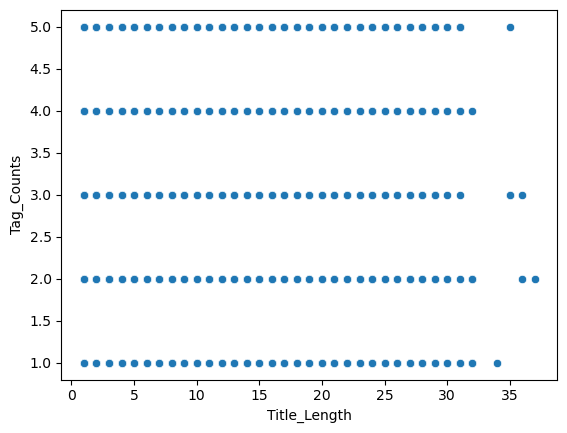

In [45]:
df_train['Title_Length'] = df_train['Title'].apply(lambda x : len(x.split()))
sns.scatterplot(x= df_train['Title_Length'], y = df_train['Tag_Counts'])

## Text preprocessing

In [46]:
def find_code(df):
    if '<code>' in df:
        return 1
    else: 
        return 0

    
df_train['is_code'] = df_train['Body'].apply(find_code)

In [47]:
df_train

,Id,Title,Body,Tags,Tag_Counts,Body_Length,Title_Length,is_code
0,1052803,What are Visual Studio project references?,<p>I came across the Framework and References ...,c++ visual-studio visual-c++ visual-studio-pro...,4,26,6,0
1,441187,How to create a report of per-day changes over...,<p>I need to generate report that will show nu...,sql-server tsql data-warehouse scd2,4,149,12,1
2,5525782,Mac OS X Java SDK Support,"<p>Can anyone tell me, or send me to a page, t...",java osx,2,138,6,0
3,4965496,Security with RijndaelManaged and ServicePoint...,<p>I have a security question about <strong>Ri...,ssl rijndaelmanaged servicepointmanager,3,445,5,1
4,2081065,"Unlocking a ""read only"" registry entry in Wind...",<p>My registry entry <code>HKEY_CURRENT_USER\S...,windows-7 windows-registry,2,43,9,1
...,...,...,...,...,...,...,...,...
499995,3440230,Pointer alignment,<p>could anyone explain (by giving appropiate ...,c++ pointers,2,18,2,0
499996,3252996,Rails Ajax -> Sinatra -> Amazon API and back,<p>I'm not sure that I really understand how S...,ruby ajax sinatra,3,181,9,1
499997,4786023,Gitflow Installation Problems,<p>I am trying to get gitflow running on Windo...,git git-flow,2,129,3,1
499998,5687092,Zero cost exception handling vs setjmp/longjmp,<p>Assuming that there is a cost associated wi...,c++ exception gcc exception-handling g++,5,132,6,1


In [48]:
print(f"There are a total of {df_train[df_train['is_code'] == 1].shape[0]} questions with code out of {df_train.shape[0]}")
print(f"{np.round((100 * df_train[df_train['is_code'] == 1].shape[0])/df_train.shape[0],2)}% of the questions has code")

There are a total of 273288 questions with code out of 485030
56.34% of the questions has code


In [49]:
# Top 30 tags used in our corpus
list_tags = tag_df_train_sorted['Tags'].head(30).to_list()

# Filtering by only those rows where the tags are in top 30
df_tags = df_train[(df_train['Tags'].isin(list_tags))][['Title','Body', 'Tags']]

# Using the title and body as one column.
df_tags['post'] = df_tags['Title'] + ' ' + df_tags['Body']

# Removing extra columns.
df_tags = df_tags.drop('Title', axis = 1).drop('Body', axis = 1)

df_tags.head(2)

,Tags,post
12,c#,How to solve the following method issue in c# ...
17,jquery,Why is my post-animate function not being call...


In [50]:
print('Original Df length: \t' + str(len(df_train)))
len_df_tags = len(df_tags)
print('df tags length: \t' + str(len_df_tags))

Original Df length: 	485030
df tags length: 	26541


In [51]:
%%time
en_stopwords = stopwords.words('english')

# HTML decoding.
df_tags['post'] = df_tags['post'].apply(lambda x: (BeautifulSoup(x, 'lxml').text).lower())

# Replacingsymbols by space in text.
df_tags['post'] = df_tags['post'].str.replace('[/(){}\[\]\|@,;]', ' ', regex=True)

# Deletting symbols from text.
df_tags['post'] = df_tags['post'].str.replace('[^0-9a-z #+_]', '', regex=True)

# Deleting stop words.
df_tags['post'] = df_tags['post'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

df_tags.head(5)

CPU times: user 24.1 s, sys: 6.4 ms, total: 24.1 s
Wall time: 24.1 s


,Tags,post
12,c#,solve following method issue c# mainstatic voi...
17,jquery,postanimate function called im animating popup...
46,jquery,triggering jquery event function page load her...
51,android,possible pass constructor parameters xml im wr...
67,python,return empty dict instead none method currentl...


In [52]:
df_tags['post'].iloc[1]

'postanimate function called im animating popups fade slide simultaneously want reset position hidden popup hidden animation every timewhen element rolled popup slides fades rolled popup slides fades hidden resets initial positionheres code rollover hover function rollover fadein fast animate top 60px duration fast queue false function function rollover fadeout fast animate top 70px duration fast queue false function consolelog hello css top 50px problem last line top reset triggered neither log statement'

In [53]:
i = 0
for items in df_tags['post']:
    print(items)
    print('------------------------------------------------------------------------------')
    
    i += 1
    
    if i > 10:
        break

solve following method issue c# mainstatic void main string args money m1 new money 231599 money m2 new money 4000 25 consolewriteline m1 consolewriteline m2 consolewriteline m1incrementmoney m2 public void incrementmoney money x put money m1 new money 231599 supposed turn 231599 231599and money m2 new money 4000 25 forms 400025i done money class works fine im supposed add two together using m1incrementmoney m2 money classclass money instance variables private int dollars private int cents double amount public int dollars get return dollars set value 0 dollars value public int cents get return cents set value 0 cents value public money int dol int cen dollars dol cents cen double dollar converttodouble dollars double cent converttodouble cents amount dollar + cent 100 public money double int dol converttoint32 dol dollars dol 1 else dol dollars dol dollars double cen 1 cen cen 100 cents converttoint32 cen cents double dollar converttodouble dollars double cent converttodouble cents amo

## ML Modeling

### Splitting the data for Train Test Split

In [54]:
X = df_tags.post
y = df_tags.Tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [55]:
X_train

418486    windowresize javascript behaves differently op...
368149    use view another controller globalization reas...
289791    hashcode string entire application working has...
302914    textarea sized content entered textarea form p...
275486    wont class call methods im trying make simple ...
                                ...                        
407775    get uri images sdcard android want get uri pat...
102876    better way validate value span newbie jquery f...
15936     precision resolution timing functions quantify...
300637    trying create dictionary know deal n subject_d...
446571    source code javalangobject web site could see ...
Name: post, Length: 18578, dtype: object

### 1. Naive Bayes Classifier

In [56]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [57]:
%%time
y_pred = nb.predict(X_test)

accuracy_Naive_Bayes = accuracy_score(y_pred, y_test)
print('accuracy %s' % accuracy_Naive_Bayes)
print(classification_report(y_test, y_pred,target_names=list_tags))

accuracy 0.37925404998116286
               precision    recall  f1-score   support

           c#       0.00      0.00      0.00        53
         java       0.00      0.00      0.00        15
          php       0.23      1.00      0.37      1230
   javascript       0.80      0.02      0.03       232
      android       0.00      0.00      0.00       104
       jquery       1.00      0.05      0.10       199
          c++       0.76      0.09      0.15       610
       python       0.81      0.23      0.35       359
       iphone       0.91      0.05      0.09       221
      asp.net       0.00      0.00      0.00        23
        mysql       0.00      0.00      0.00       107
         html       0.00      0.00      0.00        60
         .net       0.73      0.05      0.10       311
          ios       0.84      0.16      0.27       577
          sql       0.84      0.40      0.55       605
  objective-c       0.62      0.82      0.71       700
          css       0.00      0.00 

## Linear SVM

In [58]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [59]:
%%time

y_pred = sgd.predict(X_test)

accuracy_Linear_SVM = accuracy_score(y_pred, y_test)
print('accuracy %s' % accuracy_Linear_SVM)
print(classification_report(y_test, y_pred,target_names=list_tags))

accuracy 0.7660429486374482
               precision    recall  f1-score   support

           c#       0.81      0.32      0.46        53
         java       0.00      0.00      0.00        15
          php       0.76      0.98      0.86      1230
   javascript       0.74      0.68      0.71       232
      android       0.95      0.80      0.87       104
       jquery       0.76      0.57      0.65       199
          c++       0.77      0.40      0.53       610
       python       0.74      0.72      0.73       359
       iphone       0.80      0.75      0.77       221
      asp.net       0.00      0.00      0.00        23
        mysql       0.91      0.09      0.17       107
         html       0.69      0.15      0.25        60
         .net       0.78      0.69      0.73       311
          ios       0.77      0.82      0.79       577
          sql       0.76      0.78      0.77       605
  objective-c       0.74      0.93      0.83       700
          css       0.86      0.68  

## Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='liblinear')),
               ])
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=100000.0, n_jobs=1, solver='liblinear'))])

In [61]:
%%time

y_pred = logreg.predict(X_test)

accuracy_Logistic_Reg = accuracy_score(y_pred, y_test)
print('accuracy %s' % accuracy_Logistic_Reg)
print(classification_report(y_test, y_pred,target_names=list_tags))

accuracy 0.7907823684541002
               precision    recall  f1-score   support

           c#       0.78      0.34      0.47        53
         java       0.57      0.27      0.36        15
          php       0.91      0.95      0.92      1230
   javascript       0.72      0.69      0.71       232
      android       0.91      0.86      0.88       104
       jquery       0.69      0.62      0.65       199
          c++       0.60      0.65      0.63       610
       python       0.67      0.72      0.70       359
       iphone       0.79      0.87      0.83       221
      asp.net       0.50      0.13      0.21        23
        mysql       0.69      0.22      0.34       107
         html       0.56      0.23      0.33        60
         .net       0.74      0.71      0.73       311
          ios       0.80      0.82      0.81       577
          sql       0.78      0.81      0.79       605
  objective-c       0.85      0.89      0.87       700
          css       0.85      0.73  

In [62]:
df_results = pd.DataFrame([{'Naive Bayes Classifier for Multinomial Models':accuracy_Naive_Bayes, 'Linear support vector machine':accuracy_Linear_SVM, 'Logistic regression':accuracy_Logistic_Reg}]).T
df_results = df_results.rename({0:'Accuracy'}, axis=1)
df_results = df_results.sort_values(by='Accuracy', ascending=False)

display(df_results)

,Accuracy
Logistic regression,0.790782
Linear support vector machine,0.766043
Naive Bayes Classifier for Multinomial Models,0.379254


________________